# Clustering - Water
México 2020


## Librerías

In [155]:
!pip install kmodes
!pip install geopandas
!pip install pysal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
import random
from collections import defaultdict
from typing import Tuple

import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kmodes.kmodes import KModes
from pysal.lib import examples
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

# Utils

In [157]:
def explore(df: pd.DataFrame) -> pd.DataFrame:
    ex1, ex2, ex3 = random.sample(range(len(df)), 3)

    print("Dataframe total rows: ", len(df))
    df_info = pd.DataFrame(data = df.dtypes)
    not_missing_values_total = df.notnull().sum()
    not_missing_values_percent = round(not_missing_values_total/len(df)*100,2).astype(str)+" %"

    return pd.concat([df_info[0].rename("Data Type"),\
            df.T[ex1].rename("Example 1"),\
            df.T[ex2].rename("Example 2"),\
            df.T[ex3].rename("Example 3"),\
            not_missing_values_total.rename("Total Not Missing"), \
            not_missing_values_percent.rename("% of not missing values")], axis=1)

def explore_many_tables(database: Tuple[pd.DataFrame, ...]):
    for tbl in database:
        display(tbl.head())
        print('\n')
        display(tbl.describe())
        print('\n')
        display(tbl.tail())
        print('\n')
        display(explore(tbl))
        print('\n\n')    

## Data

In [238]:
calidad_subt = pd.read_csv('/content/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv', encoding='cp1252')
calidad_sup = pd.read_csv('/content/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv', encoding='cp1252')
escalas_subt = pd.read_csv('/content/Escalas_subterranea.csv', encoding='cp1252')
escalas_sup = pd.read_csv('/content/Escalas_superficial.csv', encoding='cp1252')

In [239]:
db = geopandas.read_file(examples.get_path("mexicojoin.shp"))
df =  calidad_sup

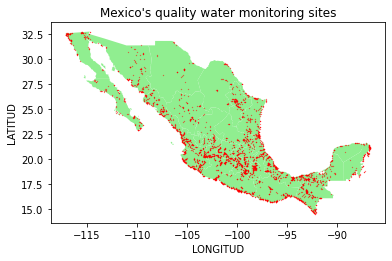

In [160]:
fig, ax = plt.subplots()
db.plot(color = "#90EE90", ax = ax)
df[["LONGITUD", "LATITUD"]].drop_duplicates().plot(kind="scatter",
                                 x="LONGITUD", 
                                 y="LATITUD", 
                                 ax = ax,
                                 color = "red",
                                 s = .05)
ax.set_title("Mexico's quality water monitoring sites")
fig.show()

In [161]:
display(calidad_sup.head())
print('\n')
display(calidad_sup.describe())
print('\n')
display(calidad_sup.tail())
print('\n')
display(explore(calidad_sup))
print('\n\n')

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,...,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
0,DLAGU8,PRESA EL SAUCILLO 100M AGUAS ARRIBA DE LA CORTINA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,RIO SAN PEDRO,PRESA EL SAUCILLO,LENTICO,PRESA,-102.33911,...,"DQO,CF,",SI,NO,SI,NO,SI,ND,SI,SI,LENTICO
1,DLBAJ100,"LOS CABOS SEG 22, 2 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN JOSE DEL CABO,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.84290,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
2,DLBAJ101,"LOS CABOS SEG 22, 1 ISA10B",PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,OCEANO PACIFICO,COSTERO,OCEANO-MAR,-109.86442,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
3,DLBAJ102,LOS CABOS 3,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.88604,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO
4,DLBAJ103,LOS CABOS 1,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LOS CABOS,SAN LUCAS,BAHIA SAN LUCAS,COSTERO,BAHIA,-109.89657,...,NaN,ND,ND,SI,ND,ND,SI,SI,SI,COSTERO


,LONGITUD,LATITUD,PERIODO,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15
count,3493.000000,3493.000000,3493.0,0.0,0.0,0.0,0.0
mean,-100.359969,21.046992,2020.0,NaN,NaN,NaN,NaN
std,6.122773,3.893696,0.0,NaN,NaN,NaN,NaN
min,-117.124030,14.534910,2020.0,NaN,NaN,NaN,NaN
25%,-103.882310,18.396070,2020.0,NaN,NaN,NaN,NaN
50%,-99.795530,20.148980,2020.0,NaN,NaN,NaN,NaN
75%,-96.860230,22.828930,2020.0,NaN,NaN,NaN,NaN
max,-86.732150,32.706500,2020.0,NaN,NaN,NaN,NaN


,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,CUENCA,CUERPO DE AGUA,TIPO,SUBTIPO,LONGITUD,...,CONTAMINANTES,CUMPLE_CON_DBO,CUMPLE_CON_DQO,CUMPLE_CON_SST,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,CUMPLE_CON_ENTEROC,CUMPLE_CON_OD,CUMPLE_CON_TOX,GRUPO
4136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Dataframe total rows:  4141


,Data Type,Example 1,Example 2,Example 3,Total Not Missing,% of not missing values
CLAVE,object,DLCOL601,DLGUE1315,OCPYU4910,3493,84.35 %
SITIO,object,CANAL VENTANAS,PLAYA LA MADERA,HUMEDAL DE IMPORTANCIA ESPECIALMENTE PARA LA C...,3493,84.35 %
ORGANISMO_DE_CUENCA,object,LERMA SANTIAGO PACIFICO,PACIFICO SUR,PENINSULA DE YUCATAN,3493,84.35 %
ESTADO,object,COLIMA,GUERRERO,YUCATAN,3493,84.35 %
MUNICIPIO,object,MANZANILLO,ZIHUATANEJO DE AZUETA,RIO LAGARTOS,3493,84.35 %
CUENCA,object,RIO MARABASCO B,RIO ZIHUATANEJO,YUCATAN (RESTO DE RH 32),3492,84.33 %
CUERPO DE AGUA,object,OCEANO PACIFICO,BAHIA DE ZIHUATANEJO,HUMEDAL DE RIA LAGARTOS,3479,84.01 %
TIPO,object,COSTERO (HUMEDAL),COSTERO,COSTERO (HUMEDAL),3493,84.35 %
SUBTIPO,object,OCEANO-MAR,BAHIA,ESTERO,3479,84.01 %
LONGITUD,float64,-104.33144,-101.55234,-87.91356,3493,84.35 %


In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4141 entries, 0 to 4140
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLAVE                   3493 non-null   object 
 1   SITIO                   3493 non-null   object 
 2   ORGANISMO_DE_CUENCA     3493 non-null   object 
 3   ESTADO                  3493 non-null   object 
 4   MUNICIPIO               3493 non-null   object 
 5   CUENCA                  3492 non-null   object 
 6   CUERPO DE AGUA          3479 non-null   object 
 7   TIPO                    3493 non-null   object 
 8   SUBTIPO                 3479 non-null   object 
 9   LONGITUD                3493 non-null   float64
 10  LATITUD                 3493 non-null   float64
 11  PERIODO                 3493 non-null   float64
 12  DBO_mg/L                2581 non-null   object 
 13  CALIDAD_DBO             2581 non-null   object 
 14  DQO_mg/L                2581 non-null   

# FEATURE SELECTION

In [163]:
class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features
    
    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]
    
        sc = StandardScaler()
        X = sc.fit_transform(X)
    
        pca = PCA(n_components=self.q).fit(X) # calculation Covmatrix is embeded in PCA
        A_q = pca.components_.T
    
        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_
    
        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))
    
        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]
            
# Usage
pfa = PFA(n_features = 5)
pfa.fit(df.select_dtypes("number").fillna(0))
# To get the transformed matrix
x = pfa.features_
print(x)
# To get the column indices of the kept features
column_indices = pfa.indices_
df_K = df.select_dtypes("number").iloc[:, column_indices].fillna(0)
df_K.head()

[[-0.47932726  0.53235948  0.          0.          0.        ]
 [-0.68272009  0.61024171  0.          0.          0.        ]
 [-0.68330339  0.60953922  0.          0.          0.        ]
 ...
 [ 2.2946097  -2.10315971  0.          0.          0.        ]
 [ 2.2946097  -2.10315971  0.          0.          0.        ]
 [ 2.2946097  -2.10315971  0.          0.          0.        ]]


,LONGITUD,LATITUD,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,CALIDAD_TOX_FIS_FON_15
0,-102.33911,22.24730,0.0,0.0,0.0
1,-109.84290,22.90473,0.0,0.0,0.0
2,-109.86442,22.89880,0.0,0.0,0.0
3,-109.88604,22.89609,0.0,0.0,0.0
4,-109.89657,22.87694,0.0,0.0,0.0


# Categorical and Numerical Data CLustering

In [241]:
df_obj = df.select_dtypes('object').nunique()

cols = []
for col in df[list(df_obj[df_obj < 100].index)].columns:
    print("NA --------", df[col].isna().sum(), round((df[col].isna().sum()*100)/len(df), 2), '% -------- NA over the totals')
    print("Minimal % per supposed category in this column", 
         round((len(df)/len(df[col].value_counts())*100)/len(df),2) 
         )
    
    # if each category has more than 10 items
    if all([i >= 10 for i in list(df[col].value_counts())]) and (round((df[col].isna().sum()*100)/len(df), 2) < 50): #if nulls don-t repersent more than 50%            
        #print((df[col].value_counts()*100)/len(df), '\n')
        if all([i >= round((len(df)/len(df[col].value_counts())*100)/len(df),2)/2 for i in list((df[col].value_counts()*100)/len(df)) ]):
            print(df[col].value_counts(), '\n')
            cols.append(col)

NA -------- 648 15.65 % -------- NA over the totals
Minimal % per supposed category in this column 7.69
NA -------- 648 15.65 % -------- NA over the totals
Minimal % per supposed category in this column 3.12
NA -------- 648 15.65 % -------- NA over the totals
Minimal % per supposed category in this column 4.35
NA -------- 662 15.99 % -------- NA over the totals
Minimal % per supposed category in this column 3.7
NA -------- 1560 37.67 % -------- NA over the totals
Minimal % per supposed category in this column 20.0
NA -------- 1560 37.67 % -------- NA over the totals
Minimal % per supposed category in this column 20.0
NA -------- 652 15.74 % -------- NA over the totals
Minimal % per supposed category in this column 20.0
NA -------- 1559 37.65 % -------- NA over the totals
Minimal % per supposed category in this column 20.0
NA -------- 1559 37.65 % -------- NA over the totals
Minimal % per supposed category in this column 20.0
NA -------- 3237 78.17 % -------- NA over the totals
Minimal 

In [242]:
print(cols)

['SEMAFORO', 'CUMPLE_CON_DQO', 'CUMPLE_CON_CF', 'CUMPLE_CON_E_COLI', 'GRUPO']


In [243]:
dfMatrix = pd.concat([df[cols].fillna(''), df.select_dtypes("number").fillna(0)], axis=1)

cost = []
for cluster in range(1, 10):
    kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
    kmodes.fit_predict(dfMatrix)
    cost.append(kmodes.cost_)
    print('Cluster initiation: {}'.format(cluster))

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


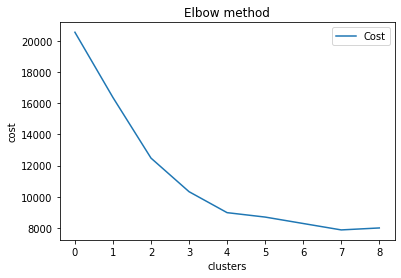

In [244]:
df_cost = pd.DataFrame({'Cost': cost})
df_cost.plot()
plt.xlabel("clusters")
plt.ylabel("cost")
plt.title("Elbow method")
plt.show()

In [245]:
dfMatrix_K =  dfMatrix[(dfMatrix["LONGITUD"] != 0) & (dfMatrix["LATITUD"] != 0)]
kmodes = KModes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
clusters = kmodes.fit_predict(dfMatrix_K)

In [248]:
# Cluster centorid
print("centroids", kmodes.cluster_centroids_)
# Check the iteration of the clusters created
print("clusters iters", kmodes.n_iter_)
# Check the cost of the clusters created
print("cost ", kmodes.cost_)

centroids [['Amarillo' 'SI' 'NO' 'NO' 'LOTICO' '-115.49845' '14.53491' '2020.0'
  '0.0' '0.0' '0.0' '0.0']
 ['Verde' 'SI' 'SI' 'SI' 'LENTICO' '-116.91139' '16.06046' '2020.0' '0.0'
  '0.0' '0.0' '0.0']
 ['Rojo' 'NO' 'NO' 'NO' 'LOTICO' '-101.84492' '19.32413' '2020.0' '0.0'
  '0.0' '0.0' '0.0']
 ['Verde' 'ND' 'ND' 'ND' 'COSTERO' '-92.32058' '14.61567' '2020.0' '0.0'
  '0.0' '0.0' '0.0']]
clusters iters 2
cost  8975.0


In [247]:
# Add the cluster to the dataframe
dfMatrix_K['Cluster Labels'] = kmodes.labels_
dfMatrix_K['Segment'] = dfMatrix_K['Cluster Labels'].map({0:'First', 1:'Second', 2:'Third', 3:'Fourth'})
# Order the cluster
dfMatrix_K['Segment'] = dfMatrix_K['Segment'].astype('category')
dfMatrix_K['Segment'] = dfMatrix_K['Segment'].cat.reorder_categories(['First', 'Second', 'Third', 'Fourth'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [249]:
dfMatrix.head()

,SEMAFORO,CUMPLE_CON_DQO,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,GRUPO,LONGITUD,LATITUD,PERIODO,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15
0,Rojo,NO,NO,SI,LENTICO,-102.33911,22.24730,2020.0,0.0,0.0,0.0,0.0
1,Verde,ND,ND,ND,COSTERO,-109.84290,22.90473,2020.0,0.0,0.0,0.0,0.0
2,Verde,ND,ND,ND,COSTERO,-109.86442,22.89880,2020.0,0.0,0.0,0.0,0.0
3,Verde,ND,ND,ND,COSTERO,-109.88604,22.89609,2020.0,0.0,0.0,0.0,0.0
4,Verde,ND,ND,ND,COSTERO,-109.89657,22.87694,2020.0,0.0,0.0,0.0,0.0


In [250]:
dfMatrix.columns

Index(['SEMAFORO', 'CUMPLE_CON_DQO', 'CUMPLE_CON_CF', 'CUMPLE_CON_E_COLI',
       'GRUPO', 'LONGITUD', 'LATITUD', 'PERIODO', 'TOX_D_48_FON_UT',
       'CALIDAD_TOX_D_48_FON', 'TOX_FIS_FON_15_UT', 'CALIDAD_TOX_FIS_FON_15'],
      dtype='object')

In [254]:
list_col = ['Cluster Labels', 'Segment']
cols = [col for col in dfMatrix_K if col not in list_col]
cols

['SEMAFORO',
 'CUMPLE_CON_DQO',
 'CUMPLE_CON_CF',
 'CUMPLE_CON_E_COLI',
 'GRUPO',
 'LONGITUD',
 'LATITUD',
 'PERIODO',
 'TOX_D_48_FON_UT',
 'CALIDAD_TOX_D_48_FON',
 'TOX_FIS_FON_15_UT',
 'CALIDAD_TOX_FIS_FON_15']

In [256]:
index = ['First Cluster', 'Second Cluster', 'Third Cluster', 'Fourth Cluster']

## Centroids

In [257]:
pd.DataFrame(kmodes.cluster_centroids_, columns = cols, index = index)

,SEMAFORO,CUMPLE_CON_DQO,CUMPLE_CON_CF,CUMPLE_CON_E_COLI,GRUPO,LONGITUD,LATITUD,PERIODO,TOX_D_48_FON_UT,CALIDAD_TOX_D_48_FON,TOX_FIS_FON_15_UT,CALIDAD_TOX_FIS_FON_15
First Cluster,Amarillo,SI,NO,NO,LOTICO,-115.49845,14.53491,2020.0,0.0,0.0,0.0,0.0
Second Cluster,Verde,SI,SI,SI,LENTICO,-116.91139,16.06046,2020.0,0.0,0.0,0.0,0.0
Third Cluster,Rojo,NO,NO,NO,LOTICO,-101.84492,19.32413,2020.0,0.0,0.0,0.0,0.0
Fourth Cluster,Verde,ND,ND,ND,COSTERO,-92.32058,14.61567,2020.0,0.0,0.0,0.0,0.0


In [258]:
unique, counts = np.unique(clusters, return_counts=True)
dict(zip(unique, counts))

{0: 1034, 1: 795, 2: 753, 3: 911}

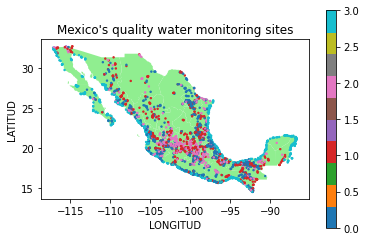

In [259]:
import matplotlib.colors as colors

fig, ax = plt.subplots()
db.plot(color = "#90EE90", ax = ax)
dfMatrix =  dfMatrix[(dfMatrix["LONGITUD"] != 0) & (dfMatrix["LATITUD"] != 0)]
dfMatrix[["LONGITUD", "LATITUD"]].plot(kind="scatter",
                                 x="LONGITUD", 
                                 y="LATITUD", 
                                 ax = ax,
                                 c = clusters,
                                 cmap = 'tab10',
                                 s = 2)
ax.set_title("Mexico's quality water monitoring sites")
fig.show()

# CLUSTER JUST NUMERICALS

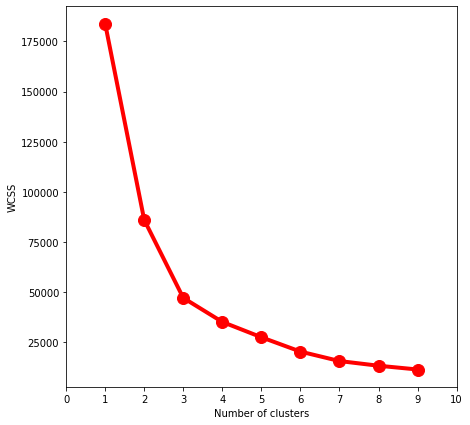

In [127]:
df_set = df[["LONGITUD", "LATITUD"]].dropna()
WCSS = []
for i in range(1, 10):
    model = KMeans(n_clusters = i,init = 'k-means++')
    model.fit(df_set)
    WCSS.append(model.inertia_)
fig = plt.figure(figsize = (7,7))
plt.plot(range(1,10),WCSS, linewidth=4, markersize=12,marker='o',color = 'red')
plt.xticks(np.arange(11))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [128]:
model = KMeans(n_clusters = 4,init = 'k-means++', random_state = 0)
clusters = model.fit_predict(df_set)

In [114]:
# Cluster centorid
print("centroids", model.cluster_centers_)
# Check the iteration of the clusters created
print("clusters", model.n_iter_)

centroids [[-111.54308103   28.33264423]
 [ -92.10845271   17.78512748]
 [-103.4497233    22.42248902]
 [ -98.86564045   19.46783703]]
clusters 13


In [115]:
# Add the cluster to the dataframe
df_set['Cluster Labels'] = model.labels_
df_set['Segment'] = df_set['Cluster Labels'].map({0:'First', 1:'Second'})
# Order the cluster
df_set['Segment'] = df_set['Segment'].astype('category')
df_set['Segment'] = df_set['Segment'].cat.reorder_categories(['First', 'Second'])

In [116]:
df_set.head()

,LONGITUD,LATITUD,Cluster Labels,Segment
0,-102.33911,22.24730,2,NaN
1,-109.84290,22.90473,0,First
2,-109.86442,22.89880,0,First
3,-109.88604,22.89609,0,First
4,-109.89657,22.87694,0,First


In [117]:
list_col = ['Cluster Labels', 'Segment']
cols = [col for col in df_set if col not in list_col]
cols

['LONGITUD', 'LATITUD']

In [121]:
index = ['First Cluster', 'Second Cluster', 'Third Cluster', 'Fourth Cluster']

In [122]:
pd.DataFrame(model.cluster_centers_, columns = cols, index = index)

,LONGITUD,LATITUD
First Cluster,-111.543081,28.332644
Second Cluster,-92.108453,17.785127
Third Cluster,-103.449723,22.422489
Fourth Cluster,-98.865640,19.467837


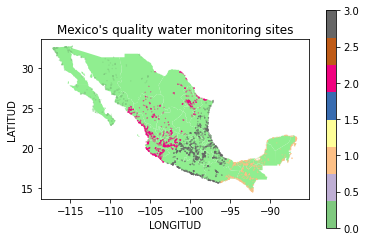

In [132]:
fig, ax = plt.subplots()
db.plot(color = "#90EE90", ax = ax)
df_set[["LONGITUD", "LATITUD"]].dropna().plot(kind="scatter",
                                 x="LONGITUD", 
                                 y="LATITUD", 
                                 ax = ax,
                                 c = clusters,
                                 cmap = 'Accent',
                                 s = .05)
ax.set_title("Mexico's quality water monitoring sites")
fig.show()